# Nodes

We've talked about how in a production environment, you'll have multiple nodes in your cluster. For this course, we've been using a single node cluster with `minikube`. The nice thing about Kubernetes is that almost everything you do with it is abstracted away from the underlying infrastructure with the `kubectl` CLI.

All the commands we've been using locally will work the same way on a production cluster.

### Ways to Deploy to Production

There are several popular ways to deploy a Kubernetes cluster to production:
- [GKE (Google Kubernetes Engine) / Autopilot](https://cloud.google.com/kubernetes-engine)
- [EKS (Amazon Elastic Kubernetes Service)](https://aws.amazon.com/eks/)
- [AKS (Azure Kubernetes Service)](https://azure.microsoft.com/en-us/products/kubernetes-service)
- [Manual Deployment](https://kubernetes.io/docs/setup/production-environment/)

### Gke, Eks, Aks


Ways to Deploy to Production

There are several popular ways to deploy a Kubernetes cluster to production:

    GKE (Google Kubernetes Engine) / Autopilot
    EKS (Amazon Elastic Kubernetes Service)
    AKS (Azure Kubernetes Service)
    Manual Deployment

Gke, Eks, Aks

These are all managed Kubernetes services, offered by the big 3 cloud providers. They're all pretty similar, though I believe GKE is generally the most feature-rich of the three. GKE also has a cool auto-pilot mode that makes it so that you don't have to worry about managing nodes at all.

The nice thing about a managed offering is that it can be configured to handle autoscaling at the node level. This means that you can set up your cluster to automatically add and remove nodes based on the load of your cluster.

### Manual

You can also set up your own cluster manually. I've worked on teams where a cloud engineering team has custom scripts that configure a cluster on top of standard EC2 instances. Then they have their own autoscaling scripts that add and remove nodes based on the load of the cluster. I happened to work at a company that manually deployed k8s to a group of AWS virtual machines, but you could also do the same thing on physical machines.

Deploying manually was more popular before the managed services were released, but it's still a viable option if you want more control over your cluster.


# Node Types

Broadly speaking, there are two types of machines in a production Kubernetes cluster:
- Control Plane
- Worker Nodes

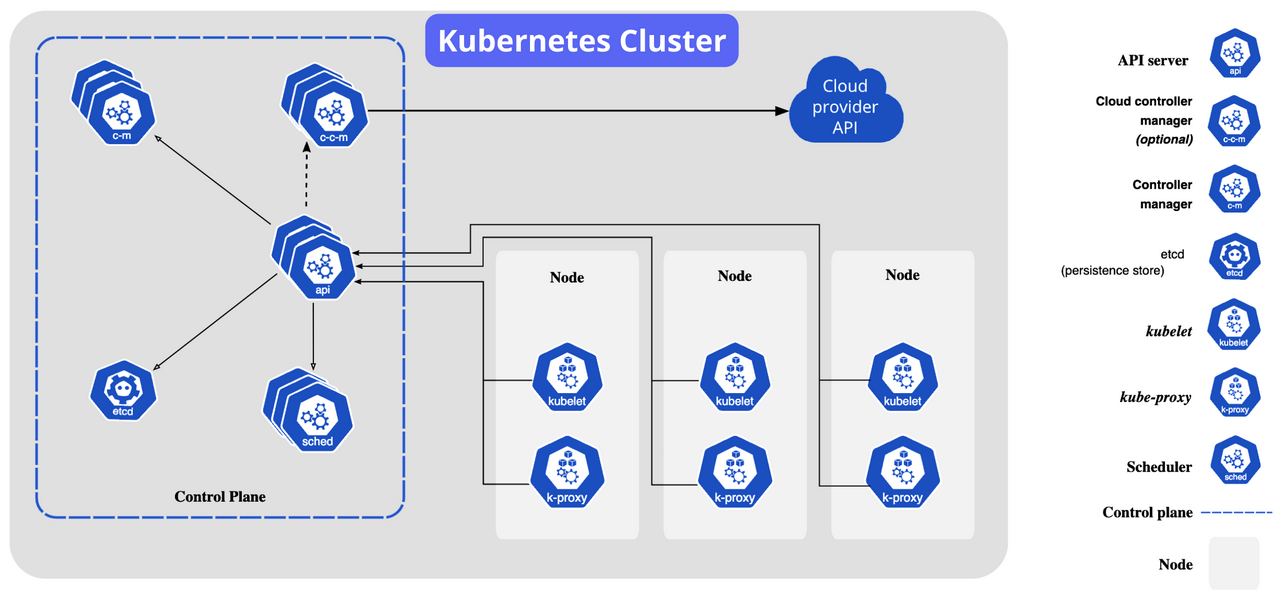

The control plane is responsible for managing the cluster. It's where the API server, scheduler, and controller manager live. The control plane used to be called "master nodes", but that term is deprecated now.

When you hear the word "node" used in isolation it's usually referring to worker nodes.

# Resource Requests

We talked about resource limits, but there's another critical concept to understand: resource requests.

A resource request is the amount of a resource that a pod requests from the node it's running on. A resource limit, on the other hand, is the maximum amount of a resource that a pod is allowed to consume before it's throttled or killed.

### Why do we need requests?

Let's say we have 2 nodes:

| Node |  RAM   |
| ---- | ------ |
|  N1  | 8GB    |
|  N2  | 8GB    |

And we have 4 pods:

|  Pod  | Node |  RAM  |
| ----- | ---- | ----- |
| Pod 1 |  N1  | 3GB   |
| Pod 2 |  N1  | 3GB   |
| Pod 3 |  N2  | 3GB   |
| Pod 4 |  N2  | 3GB   |

This is valid. Currently, only 6/8 GB of RAM is being used on each node. The trouble is, even though each node has 2GB of RAM left, if we try to add another pod, and it ends up utilizing more than 2GB of RAM (like the 3GB it will likely need), it will crash.


*Resource requests solve this.*

If we add a resource request of 3GB, Kubernetes will know that each pod needs 3GB of RAM to run. If we try to [schedule](https://kubernetes.io/docs/concepts/configuration/manage-resources-containers/#how-pods-with-resource-requests-are-scheduled) a new pod with the request in place, k8s will gracefully tell us it doesn't have enough resources to do so, or it will use a node in the cluster that has at least 3GB of RAM available.

Let's set an absurdly high resource request for our `synergychat-testram` pods.

To keep my system save without any crashing, the `resources` section will be limits at 16GB:

```yaml
resources:
  limits:
    memory: 16000Mi
  requests:
    memory: 16000Mi
```

You can set the value based on your own system

Apply the deployment, you should see that the pod is "Pending", once it in that state, `describe` the pod and look at the "Events" section of the output to see what going on:

```python
kubectl describe pod <pod-name>
```

# Requests

One of the most important things to get right when working with pod autoscalers in Kubernetes are the resource requests and limits. If you don't set them correctly, you can end up with a situation where your pods are crashing, or your autoscaler is scaling up too many pods.

Generally speaking, my rule of thumb is:
- Set memory requests ~10% higher than the average memory usage of your pods
- Set CPU requests to 50% of the average CPU usage of your pods
- Set memory limits ~100% higher than the average memory usage of your pods
- Set CPU limits ~100% higher than the average CPU usage of your pods


Why these numbers? Consider several points:

### Memory is Scarier

Memory is the scariest resource to run out of. If you run out of CPU, your pods will just slow down. If you run out of memory, your pods will crash. For that reason, it's more important to add a buffer to your memory requests than your CPU requests.

### Limits Are for Protection

Limits should only take effect when a pod is using more resources than it should. Limits are like a safety net. If your limits are constantly being hit, you should either increase them or fix your application code so that it uses fewer resources.

As such, limits should generally be set higher than requests.


### Requests are for Scheduling

Because requests are used to schedule pods, you want to make sure that your requests are high enough that once scheduled, your pods will have the resources, but not so high that you're wasting resources. If you set your requests too high, you'll end up with a situation where you can't schedule pods because k8s thinks it doesn't have enough resources, even though it does.

### It All Depends

These are just rules of thumb! At the end of the day, you always need to understand how your applications work, and what resources they need. The right numbers for your applications might be drastically different than the numbers I've suggested here.